In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import import_ipynb
from EDA_limpieza import df_refugees, df_prices, df_equipment, df_personnel
from utils.hypothesis_functions import *
from utils.clean_functions import decumulate_columns, index_by_datetime


## Hipótesis 1

Se espera que los precios en Ucrania oscilen en función del número de refugiados que huyen del país y de la cercanía al frente de los puestos de venta. Asimismo, un peor rendimiento por parte del bando ruso debería animar a los proveedores a vender en el país y aumentar la oferta

(Más refugiados, mayor lejanía del frente o más pérdidas rusas = precios más bajos)

### Proceso

- Miro el dataframe "df_prices"

In [20]:
df_prices.head()


,usdprice,market,commodity
date,,,
2022-03-15,4.8148,Rivne,Antibiotics (imported)
2022-03-15,1.0399,Rivne,Antibiotics (local)
2022-03-15,0.4625,Rivne,Antipyretic (local)
2022-03-15,0.3667,Rivne,Vasodilating agents (local)
2022-03-15,1.5907,Rivne,Vasodilating agents (imported)


- Separo el dataframe entre medicamentos locales o importados
- Creo una función ad hoc (create_lmplot_w_regression_line) que me dibuja un gráfico de tipo lmplot pero que, dado que voy a necesitar un par (el de importados y el de locales), y serán muy parecidos, que lo haga con algunos valores por defecto. Así me ahorro escribir lo mismo dos veces. No me la llevo a utils porque solo sirve para este caso

In [21]:
'''Creates a seaborn lmplot with regression lines using a few default values'''
def create_lmplot_w_regression_line(data, x="longitude", y="usdprice", hue="commodity", xlabel='Longitude East', ylabel=None, title=None):
    '''Requires a dataframe and two column names. Other parameters are optional and homonym to the ones used in a seaborn lmplot'''
    sns.lmplot(data=data, x=x, y=y, hue=hue)
    plt.ylabel(ylabel=ylabel)
    plt.xlabel(xlabel=xlabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()  


df_prices_imported = df_prices[df_prices['commodity'].str.contains('imported')]
df_prices_local = df_prices[df_prices['commodity'].str.contains('local')]

create_lmplot_w_regression_line(df_prices_imported, ylabel='Price in USD', title='Imported medicine price by distance to the front (with regression line)')
create_lmplot_w_regression_line(df_prices_local, title='Local medicine price by distance to the front (with regression line)')


KeyError: "['longitude'] not in index"

- Salta a la vista que una mayor distancia al frente no reduce necesariamente el precio de las medicinas
- Se nota, también, que los precios de los importados son muy superiores
- El precio de los locales oscila mucho para los tres medicamentos, lo vemos por la distancia que hay entre los puntos y la recta de regresión, lo que hace pensar que no hay un suministro estable. Eso explicaría que se importen tantos como para que Naciones Unidas los haya clasificado en dos grupos
- Ocurre lo mismo con los antibióticos de importación. Como no necesito ya la distancia al frente, me basta con calcular la desviación típica de los precios para hacerme una idea de cuán superior es la dispersión de los antibióticos

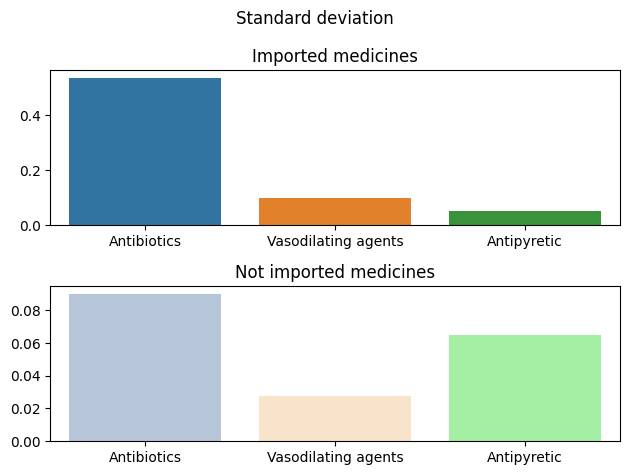

In [ ]:
df_imp_antibiotics, df_imp_antipyretic, df_imp_vasodilating = [table for med, table in df_prices_imported.groupby('commodity')]
df_loc_antibiotics, df_loc_antipyretic, df_loc_vasodilating = [table for med, table in df_prices_local.groupby('commodity')]

plt.subplot(2, 1, 1)
sns.barplot(x=['Antibiotics','Vasodilating agents','Antipyretic'], y=[df_imp_antibiotics['usdprice'].std(), df_imp_vasodilating['usdprice'].std(), df_imp_antipyretic['usdprice'].std()])
plt.title('Imported medicines')
plt.subplot(2, 1, 2)
sns.barplot(x=['Antibiotics','Vasodilating agents','Antipyretic'], y=[df_loc_antibiotics['usdprice'].std(), df_loc_vasodilating['usdprice'].std(), df_loc_antipyretic['usdprice'].std()], 
                                                                    palette = ['lightsteelblue','bisque', 'palegreen']
            )
plt.title('Not imported medicines')
plt.suptitle('Standard deviation')
plt.tight_layout()
plt.show()


- La desviación típica es mayor en el caso de los antibióticos comparada con los otros dos para ambos casos, eso está claro. Ahora bien, ¿puedo estudiarlos juntos, los locales y los importados? De entrada, parecería que la mayor desviación típica en el caso de los importados es un fenómeno a parte, por el contraste de los antibióticos con los otros dos medicamentos importados, muy bajos ambos. Pero, ¿de veras ha cambiado su desviación si la comparamos con la de los antibióticos locales? 
- Compruebo el punto anterior con un ftest (función: ftests_stds) cuya hipótesis 0 es que las desviaciones estándar son iguales. El resultado es que la proporción solo se mantiene para los antipiréticos
- Lo que ocurre probablemente sea lo siguiente: los agentes vasodilatadores, los antipiréticos y los antibióticos locales sufren escasez, y por eso los precios oscilan (la demanda es el principal factor que hace oscilar los precios de un mercado). Cuando el precio oscila, la gente recurre a los importados, que son más caros. Como el suministro de agentes vasodilatadores y antipiréticos importados no llega a escasear, la desviación estándar es baja (probablemente se reduce en caso de los antipiréticos, y se queda igual en el caso de los vasodilatadores, como vemos con el ftest, porque ya era bastante baja). En cambio, la oscilación de los antibióticos sigue presente con los importados, si bien en una medida distinta a los locales como demuestra el ftest

In [ ]:
print("Antibióticos importados y locales, ¿mantienen la proporción?:")
print(ftest_stds(df_imp_antibiotics['usdprice'], df_loc_antibiotics['usdprice']))
print("Antipiréticos importados y locales, ¿mantienen la proporción?:")
print(ftest_stds(df_imp_antipyretic['usdprice'], df_loc_antipyretic['usdprice']))
print("Vasodilatadores importados y locales, ¿mantienen la proporción?:")
print(ftest_stds(df_imp_vasodilating['usdprice'], df_loc_vasodilating['usdprice']))


Antibióticos importados y locales, ¿mantienen la proporción?:
(False, 2.220446049250313e-16)
Antipiréticos importados y locales, ¿mantienen la proporción?:
(True, 0.21754837699983753)
Vasodilatadores importados y locales, ¿mantienen la proporción?:
(False, 7.527312106958561e-14)


Solo queda una cosa por comprobar: ¿tan grave es esa oscilación de precios? Para descubrirlo, creo una función que calcula el índice de Gini (calculate_gini). Normalmente el Gini se usa para comprobar si un reparto es equitativo; aquí me sirvo de él para ver si los costes de los medicamentos se reparten de forma justa entre los diferentes mercados. Necesito, para ello, la media (o la mediana) de precios de cada mercado

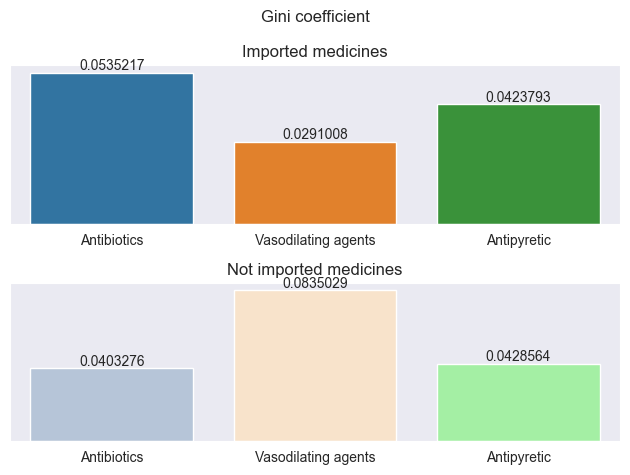

In [ ]:
with sns.axes_style("dark"):
    fig, ax = plt.subplots(2)
    sns.barplot(x=['Antibiotics','Vasodilating agents','Antipyretic'], y=[calculate_gini(df_imp_antibiotics[['usdprice','market']].groupby('market').mean(), 'usdprice')[0], 
                                                                        calculate_gini(df_imp_vasodilating[['usdprice','market']].groupby('market').mean(), 'usdprice')[0], 
                                                                        calculate_gini(df_imp_antipyretic[['usdprice','market']].groupby('market').mean(), 'usdprice')[0], 
                                                                        ],
                                                                        ax=ax[0]
                )
    ax[0].set_title('Imported medicines')

    sns.barplot(x=['Antibiotics','Vasodilating agents','Antipyretic'], y=[calculate_gini(df_loc_antibiotics[['usdprice','market']].groupby('market').mean(), 'usdprice')[0], 
                                                                        calculate_gini(df_loc_antipyretic[['usdprice','market']].groupby('market').mean(), 'usdprice')[0], 
                                                                        calculate_gini(df_loc_vasodilating[['usdprice','market']].groupby('market').mean(), 'usdprice')[0]
                                                                        ],
                                                                        ax=ax[1],
                                                                        palette = ['lightsteelblue','bisque', 'palegreen']
                )

    for number in range (0,2):
        for i in ax[number].containers:
            ax[number].set_yticks([])
            ax[number].bar_label(i,)

    ax[1].set_title('Not imported medicines')
    fig.suptitle('Gini coefficient')

    fig.tight_layout()
    plt.show()


- El resultado es tan concluyente (muy alejado de 1) que da igual, para el caso, investigar si es mejor servirse de la media o la mediana, así que lo dejo con la media
- El índice de Gini está cerca de 0 para todos los medicamentos, lo cual indica que un usuario de a pie no se dará cuenta con facilidad de que el precio varía de ciudad a ciudad
- Por ende, aunque la dispersión de los antibióticos pueda ser un síntoma de escasez, esos cambios en los precios no son tan grandes como para considerarse injustos. Por tanto, sin tener en cuenta el ya de por si elevado precio de los medicamentos importados, la preocupación debería ser la posibilidad de que falten antibióticos antes que el efecto de la dispersión de los precios en el bolsillo de los compradores ucranianos

- Quiero comprobar, ahora, si los precios oscilan con las bajas rusas, personales y materiales. La cuestión es que los precios los tengo calculados mensualmente, mientras que las bajas, diariamente. Quiero saber, para cada mes que aparece en el índice de los precios (df_prices), cuantas bajas ha habido durante el mes previo en las tablas de bajas
- Por ejemplo, si en la tabla de precios tengo el mes 2022-05-15, quiero sumar las bajas desde 2022-05-14 hasta 2022-04-15... y así para cada mes de la tabla de precios (excepto el primero, ya que se trata de 2022-03-15, y no hay cuenta de bajas antes del 2022-02-25)
- Para ello, creo una función (date_index_to_monthly)

In [ ]:
datetimes_to_study = df_prices.index.drop_duplicates()
df_monthly_personnel_datetime, df_monthly_personnel = date_index_to_monthly(df_personnel, 'personnel', 'Personnel losses', datetimes_to_study[1:])
df_monthly_equipment_datetime, df_monthly_equipment =  date_index_to_monthly(df_equipment, 'total losses', 'Equipment losses', datetimes_to_study[1:])


- Con esto ya puedo crear un gráfico de las bajas mes a mes. Ahora bien, si quiero hacerme una idea general, necesito, también, gráficos de precios por mes para cada uno de los tipos de medicamentos (6 en total, contando importados y locales). Como deberé calcular una cifra para cada mes que aglutine todas las ciudades, me toca decidir de nuevo entre la media y la mediana. Esta vez sí que hay que tenerlo en cuenta, ya que no busco un coeficiente con un resultado tan contundente, sino hacer una comparativa visual
- Como quiero ver la tendencia con claridad (y que no quede emborronada por algún outlier) y no me preocupan tanto los valores concretos, me sirvo de la mediana
- Elimino la columna "longitude" de df_prices, que no la necesito
- Itero por cada posible medicamento (soy consciente de que podría usar un groupby de entrada en lugar de iterar por los nombres de los medicamentos, pero prefiero crear una lista a mano que me permita sacar los subplots en el orden que yo quiero, por una cuestión estética), saco la media de todas ciudades para cada fecha, borro el índice inicial (que no aparece en la tabla de bajas por razones ya expuestas), y, así, voy creando cada gráfica. Utilizo una función (apply_where_groupby_mean_drop) para buena parte del proceso porque sé que tendré que hacerlo de nuevo más adelante

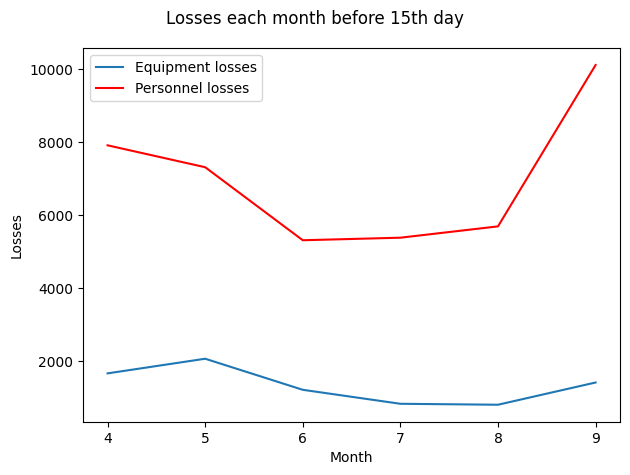

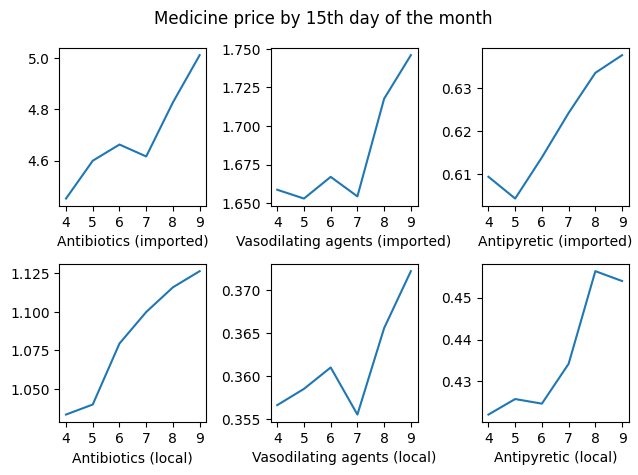

In [ ]:
sns.lineplot(df_monthly_equipment)
sns.lineplot(df_monthly_personnel, palette=['r'])
plt.ylabel(ylabel="Losses")
plt.xlabel(xlabel="Month")
plt.suptitle('Losses each month before 15th day')
plt.tight_layout()
plt.show()

df_prices.drop(columns='longitude', inplace=True)

commodities = ['Antibiotics (imported)', 'Vasodilating agents (imported)', 'Antipyretic (imported)', 'Antibiotics (local)',  'Vasodilating agents (local)', 'Antipyretic (local)']
count = 0
for element in commodities:
    df_prices_monthly_single_med = apply_where_groupby_mean_drop(df_prices, 'commodity', 'date', element, index_drops=['2022-03-15'], median=True)
    df_prices_monthly_single_med.index = ['4', '5', '6', '7', '8', '9']
    count +=1
    plt.subplot(2, 3, count)
    sns.lineplot(df_prices_monthly_single_med)
    plt.legend('',frameon=False)
    plt.xlabel(xlabel=element)
plt.suptitle('Medicine price by 15th day of the month')
plt.tight_layout()
plt.show()


- Como veo que en el mes 6 se producen cambios importantes en todas las gráficas, calculo la correlación total, así como la de antes y a partir de ese punto
- Antes de hacerlo, sin embargo, tengo que elegir entre las bajas de personal y las materiales. Ambas siguen una tendencia similar, pero la de personal parece más pronunciada. Creo que puede dar resultados más claros en caso de hacer una correlación. Lo compruebo con el coeficiente de asimetría de Fisher

In [ ]:
print(df_monthly_equipment.skew())
print(df_monthly_personnel.skew())


Equipment losses    0.401188
dtype: float64
Personnel losses    0.989514
dtype: float64


- El coeficiente de asimetría de las bajas de personal está mucho más cerca de 1 porque, si bien en ambos casos hay una asimetría por la derecha (se "hunden" por la derecha), en su caso el desequilibrio es mayor. Ello confirma la corazonada que he tenido al ver la gráfica. Así pues, decido usar las bajas de personal para el cálculo de la correlación
- Creo una lista de listas con los índices que tengo que eliminar para calcular las 3 diferentes correlaciones (recordemos: total, antes del mes 6 y después del mes 6)
- Con la misma función de antes, creo subconjuntos con cada medicamento y la mediana de los precios de las ciudades para cada fecha, pero, esta vez, voy liquidando los índices que no me interesan para cada caso mediante el argumento index_drops
- Cada subconjunto lo fusiono con el dataframe de personal que he creado antes con la función date_index_to_monthly. Es lo mismo que el df_monthly_personnel que he usado para el lineplot de bajas, pero con fechas en el índice (es necesario que sea así para la fusión)
- Meto en una lista cada vector con los números correspondientes a los meses que me interesan, y, luego, todas las listas en una lista más grande
- Con esa lista de listas ya puedo crear el gráfico de correlación

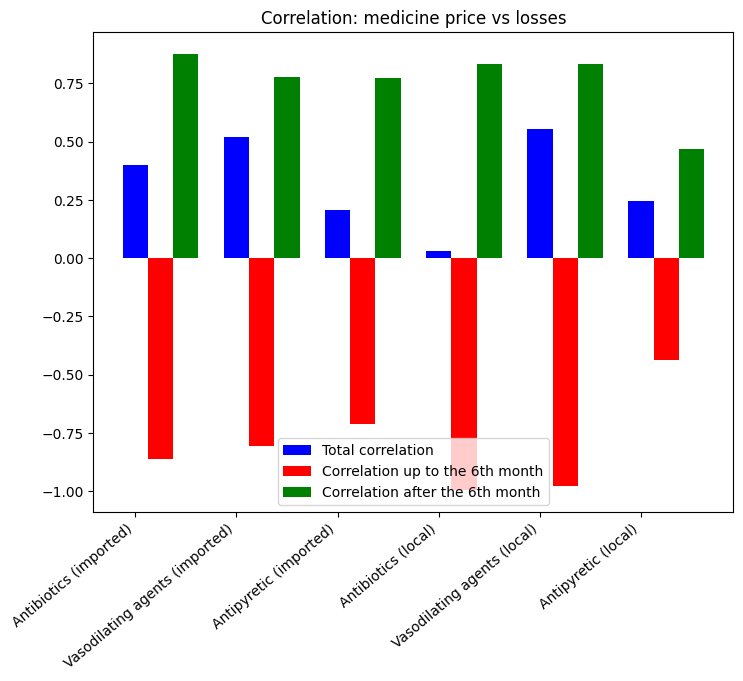

In [ ]:
total_index_drops = [['2022-03-15'], ['2022-03-15', '2022-07-15', '2022-08-15', '2022-09-15'], ['2022-03-15', '2022-04-15', '2022-05-15', '2022-06-15']]

corr_vectors = []
for index_drops in total_index_drops:
       corr_vector = []
       for element in commodities:
              df_prices_monthly_single_med = apply_where_groupby_mean_drop(df_prices, 'commodity', 'date', element, index_drops=index_drops, median=True)
              df_price_personnel = df_prices_monthly_single_med.merge(df_monthly_personnel_datetime, left_index=True, right_index=True)
              corr_vector.append(df_price_personnel.corr()['usdprice'][1])
       corr_vectors.append(corr_vector)

X = np.arange(6)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, corr_vectors[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, corr_vectors[1], color = 'r', width = 0.25)
ax.bar(X + 0.50, corr_vectors[2], color = 'g', width = 0.25)
plt.xticks([0, 1, 2, 3, 4, 5], commodities)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.legend(labels=['Total correlation', 'Correlation up to the 6th month', 'Correlation after the 6th month'])
plt.title('Correlation: medicine price vs losses')
plt.show()


Veo que la correlación cambia totalmente de sentido en ambos casos, y lo hace de manera contundente. Podemos concluir, pues:
- En términos generales, las bajas y los medicamentos están inversamente correlacionados, aunque de un modo poco tajante
- Antes del mes 6, van en la dirección contraria
- Sin embargo, a partir del mes 6, van en la misma, y se vuelve muy palpable
- En conclusión, no parece que una afecte a la otra (los medicamentos suben siempre, y las bajas primero bajan y luego suben)
- La hipótesis 2 estudia las bajas personales comparadas con las de equipamiento. Será interesante ver qué ocurre el mes 6 para que se produzca tal cambio

- Solo queda comprobar si los refugiados siguen una tendencia similar a lo que ya hemos visto; es decir, si pasa algo con ellos en el mes 6
- Echo un vistazo a la tabla

In [ ]:
df_refugees['country'].value_counts()

Hungary                     106
Slovakia                    105
Poland                      102
Republic of Moldova         102
Romania                      93
Belarus                      76
Russian Federation           70
Other European countries     11
Name: country, dtype: int64

- La situación es complicada. Quiero saber los refugiados que hay totales los días 15 de cada mes (los del índice de la tabla mensual de precios, pero sin contar el último, ya que la tabla de refugiados acaba el 2022-09-13). Sin embargo, puedo intuir que habrá países para los que no se harán las cuentas todos los meses, y mucho menos el día 15.
- Necesito una función que, por cada día 15 de esos, me mire para qué países hay datos y los sume. Si no encuentra datos para algún país, que mire en la fecha más cercana (el día 16, si acaso existe en el dataframe) para obtener una aproximación. Si sigue sin encontrar nada, que mire en la fecha siguiente... y así sucesivamente hasta haber sumado los datos de todos los países para (más o menos) ese día 15. Luego, la función debe hacer lo mismo para el resto de días 15 de cada mes. Al final, debe devolver un dataframe con el total de refugiados por fecha
- Soy consciente de que lo que obtenga será una aproximación, dado que no todos los valores sumados saldrán realmente del 15 de cada mes. Sin embargo, como la fuente es un acumulado con valores bastante grandes, si procuro que no se alejen demasiado de la fecha que les corresponde (no más de 15 días), creo que obtendré un resultado razonable para detectar una tendencia general
- Tengo la función, se llama sum_by_duplicated_values_and_datetime. Con cada uso, la función imprime el proceso que va haciendo. Con este método, puedo ir calibrando si, para algún país, se aleja demasiado del día 15 a la hora de hacer su aproximación, y valorar si tengo que eliminarlo de la tabla
- Tras varios usos, estos son los países que me veo obligado a desechar: solo uno, "Other European countries", que ya se aleja lo indecible de la primera fecha 15 en la primera vuelta, pues no es capaz de rellenar ni un mes (todos sus valores deben ser anteriores al 2022-03-15). Ninguno más, ya que los datos para el resto de países se encuentran antes de llegar al 30 del propio mes, con lo que considero que son una aproximación válida.

In [ ]:
condition = df_refugees[(df_refugees['country'] == 'Other European countries')].index
df_refugees.drop(condition, inplace=True)

df_monthly_refugees = sum_by_duplicated_values_and_datetime(df_refugees, 'country', 'individuals', datetimes_to_study[:-1])


Now checking for 2022-03-15 00:00:00
2022-03-15 00:00:00 has been filled


Now checking for 2022-04-15 00:00:00
Missing: ['Russian Federation', 'Belarus']
Add 1 day/s. Current date: 2022-04-16 00:00:00
Missing: ['Russian Federation', 'Belarus']
Add 1 day/s. Current date: 2022-04-17 00:00:00
Missing: ['Russian Federation', 'Belarus']
Russian Federation found at 2022-04-17 00:00:00
Belarus found at 2022-04-17 00:00:00
2022-04-15 00:00:00 has been filled


Now checking for 2022-05-15 00:00:00
Missing: ['Belarus']
Add 1 day/s. Current date: 2022-05-16 00:00:00
Missing: ['Belarus']
Add 1 day/s. Current date: 2022-05-17 00:00:00
Missing: ['Belarus']
Add 1 day/s. Current date: 2022-05-18 00:00:00
Missing: ['Belarus']
Add 1 day/s. Current date: 2022-05-19 00:00:00
Missing: ['Belarus']
Add 1 day/s. Current date: 2022-05-20 00:00:00
Missing: ['Belarus']
Add 1 day/s. Current date: 2022-05-21 00:00:00
2022-05-21 00:00:00 does not exist in the dataframe
Add 1 day/s. Current date: 2022-05-22 00:00:0

- Desacumulo df_refugees (decumulate_columns), me llevo la fecha al índice (index_by_datetime), borro el primer mes (ya que no hay con qué desacumularlo), modifico el índice para mostrar solo los meses y tengo la tabla resultante

In [ ]:
decumulate_columns(df_monthly_refugees, excluded='date')
index_by_datetime(df_monthly_refugees, name='date')

df_monthly_refugees.drop(index='2022-03-15', inplace=True) 
df_monthly_refugees.index = ['4', '5', '6' , '7', '8']

df_monthly_refugees


,Total
4,1811671
5,1338294
6,1490797
7,1844112
8,1652311


- A partir de ahí hago la gráfica. Detecto que, efectivamente, entre el mes 6 y el 7 los refugiados se disparan

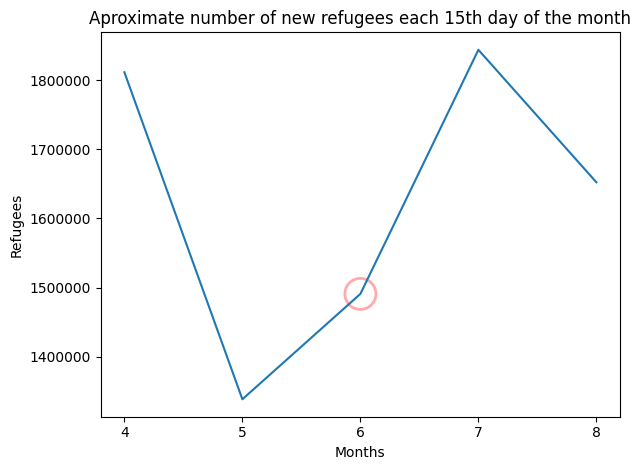

In [ ]:
fig, ax = plt.subplots()
ax.scatter(2, 1490797, s=500, edgecolor='#ff575a', lw=2, facecolor='none', alpha=0.5, zorder=1)
sns.lineplot(y=df_monthly_refugees['Total'], x=df_monthly_refugees.index)
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel(ylabel='Refugees')
plt.xlabel(xlabel='Months')
plt.title('Aproximate number of new refugees each 15th day of the month')
plt.tight_layout()
plt.show()


Conclusiones de la hipótesis 1:

A)
- No hay relación palpable entre la cercanía al frente y el precio de la medicina (la guerra moderna, con artillería de larga distancia y bombardeos, y con un frente maleable, implica que todas las ciudades sean susceptibles de sufrir problemas puntuales de suministramiento independientemente de su proximidad al enemigo)
- El precio de la medicina local varía más según el lugar (siendo estos más baratos que los de importación, y tratándose de una situación de guerra, probablemente se produzcan frecuentes desequilibros entre oferta y demanda)
- El precio de la medicina de importación es más estable, excepto en el caso de los antibióticos (siendo estos más caros que los locales, probablemente la gente recurra a ellos cuando los locales no están disponibles, con lo que se producen menos desequilibros entre oferta y demanda que alteren el precio. Por esa razón, los cambios en el precio de los antibióticos importados podrían indicar -siendo estos, además, mucho más caros-, una escasez de antibióticos en general)
- A pesar de ello, es poco probable que las diferencias en el precio de los medicamentos, por sí solas, supongan un problema para los consumidores, ya que el índice de Gini es bajo para todos

B)
- No hay una relación palpable entre el precio de la medicina y las pérdidas rusas. En términos generales, el precio de la medicina sube, mientras que las pérdidas primero bajan y luego suben
- Es a partir del mes 6 que las bajas rusas vuelven a subir

C)
- Los refugiados mensuales se disparan entre el mes 6 y el 7, momento en que hemos visto que las bajas rusas empiezan a subir (es probable que la guerra se recrudezca en este punto)
- En la hipótesis 2 se comparan bajas rusas personales y materiales por fecha. Quizás se encuentren pistas para saber lo que pasa alrededor del mes 6